# FEA Bending Modes

In [38]:
import numpy as np
import pandas as pd
import scipy.io

import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../')
from M1S_tools import *

plt.jet()

%matplotlib inline

<Figure size 640x480 with 0 Axes>

In [152]:
dataFolder = '/Users/bxin/Library/CloudStorage/OneDrive-SharedLibraries-GMTOCorp/M1S Portal - Documents'

TRDate = '20Dec2024'
TRDate = '05Jan2025'
TRDate = '07Jan2025'

TRIFFolder = '/influnce_matrix_files/OA_influence_matrices_all/OA_surface_normal_normalised_%s/'%TRDate
#read Afz (Fz influence matrix) - 01/02/2025. Trupti confirmed on slack that this is surface normal
df = pd.read_csv(dataFolder+TRIFFolder+'Afz-nohp-%s-%s-%s.csv'%(TRDate[:2],TRDate[2:5],TRDate[5:]), header=None)
Afz = np.array(df)
print('Afz = ',Afz.shape)
# this is Afz only; it is 28789 x 176. last 6 being HPs

#read Afx (Fx influence matrix)
df = pd.read_csv(dataFolder+TRIFFolder+'Afz-nohp-%s-%s-%s.csv'%(TRDate[:2],TRDate[2:5],TRDate[5:]), header=None)
Afx = np.array(df)
print('Afx = ', Afx.shape)

#read Afy (Fy influence matrix)
df = pd.read_csv(dataFolder+TRIFFolder+'Afz-nohp-%s-%s-%s.csv'%(TRDate[:2],TRDate[2:5],TRDate[5:]), header=None)
Afy = np.array(df)
print('Afy = ', Afy.shape)

Afz =  (28789, 170)
Afx =  (28789, 170)
Afy =  (28789, 170)


In [153]:
dataFolder = '/Users/bxin/Library/CloudStorage/OneDrive-SharedLibraries-GMTOCorp/M1S Portal - Documents'

TRDate = '08Jan2025'

TRIFFolder = '/influnce_matrix_files/OA_influence_matrices_all/OA_surface_normal_mormalised_%s/'%TRDate
#read Afz (Fz influence matrix) - 01/02/2025. Trupti confirmed on slack that this is surface normal
df = pd.read_csv(dataFolder+TRIFFolder+'Afz-nohp-%s-%s-%s.csv'%(TRDate[:2],TRDate[2:5],TRDate[5:]), header=None)
Afz1 = np.array(df)
print('Afz = ',Afz1.shape)
# this is Afz only; it is 28789 x 176. last 6 being HPs

Afz =  (27547, 170)


In [146]:
#read Fz Bending Modes & forces (note: Uzm is for the moments.)
df = pd.read_csv(dataFolder+TRIFFolder+'Uz_norm-nohp-%s-%s-%s.csv'%(TRDate[:2],TRDate[2:5],TRDate[5:]), header=None)
UMat = np.array(df)
print('U matrix', UMat.shape)

df = pd.read_csv(dataFolder+TRIFFolder+'Sz_norm-nohp-%s-%s-%s.csv'%(TRDate[:2],TRDate[2:5],TRDate[5:]), header=None)
SMat = np.array(df)
print('S matrix', SMat.shape)

df = pd.read_csv(dataFolder+TRIFFolder+'Vz_norm-nohp-%s-%s-%s.csv'%(TRDate[:2],TRDate[2:5],TRDate[5:]), header=None)
VMat = np.array(df)
print('V matrix', VMat.shape)

U matrix (28789, 170)
S matrix (170, 170)
V matrix (170, 170)


In [154]:
#read FEA nodes data
TRIFFolderOld = '/influnce_matrix_files/OA_influence_matrices_all/OA_surface_normal_normalised_%s/'%'20Dec2024'
df = pd.read_csv(dataFolder+TRIFFolderOld+'surfacenodes_M1B-20-Dec-2024.csv')
nodeID = np.array(df['nodeID'])
nodex = np.array(df['X'])
nodey = np.array(df['Y'])
nodez = np.array(df['Z'])
print('N node = ', len(nodeID), len(nodex))

N node =  28789 28789


In [155]:
# use these indices to remove surface nodes outside of CA
noder = np.sqrt(nodex**2+nodey**2)
insideCA = noder< np.max(nodex_ml) #diameter_of_CA/2.0
nodeID = nodeID[insideCA]
nodex = nodex[insideCA]
nodey = nodey[insideCA]
nodez = nodez[insideCA]
Afz = Afz[insideCA, :]

[[2.05022365e-09 1.37232774e-09 7.13583949e-10]
 [2.01904394e-09 1.35469314e-09 7.01017322e-10]
 [1.97760889e-09 1.33069226e-09 6.83850134e-10]] 
 [[2.00023068e-09 1.33224152e-09 6.88065924e-10]
 [1.96904454e-09 1.31459649e-09 6.75483248e-10]
 [1.92760307e-09 1.29058518e-09 6.58300012e-10]]


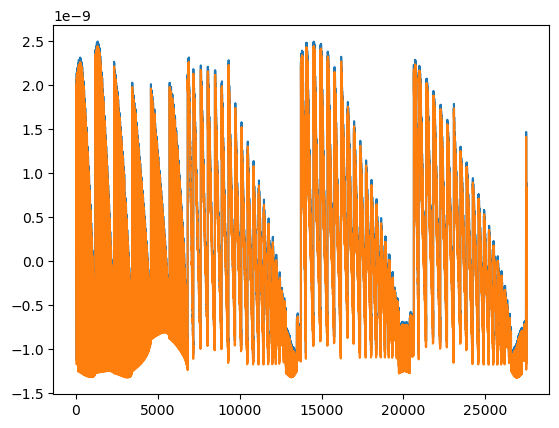

In [165]:
plt.plot(Afz[:,0])
#diff = Afz[:,0]-Afz1[:,0]
#plt.plot(diff)
#plt.plot(diff/Afz[:,0])
plt.plot(Afz1[:,0])
print(Afz[:3,:3], '\n', Afz1[:3,:3])

### check Trupti's matrices

In [150]:
#is TR still doing SVD with HPs included??????????????
print(UMat.shape, VMat.shape, SMat.shape)

(28789, 170) (170, 170) (170, 170)


In [151]:
#did she exclude nodes beyond 4.18m?
print(UMat.shape, SMat.shape, VMat.shape, Afz.shape)

(28789, 170) (170, 170) (170, 170) (27547, 170)


In [61]:
print(Afz[:3,:3])

#reconstruct Afz using U,S,V from Trupti
aa = UMat@SMat@VMat.transpose()/170
print(aa[:3,:3])

[[2.05022365e-09 1.37232774e-09 7.13583949e-10]
 [2.01904394e-09 1.35469314e-09 7.01017322e-10]
 [1.97760889e-09 1.33069226e-09 6.83850134e-10]]
[[2.05022365e-09 1.37232774e-09 7.13583949e-10]
 [2.01904394e-09 1.35469314e-09 7.01017322e-10]
 [1.97760889e-09 1.33069226e-09 6.83850134e-10]]


In [62]:
#check BM normalization
print("manually calculated RMS; numpy STD; numpy mean")
for i in np.arange(1,165,10):
    print('%.2f, %.2f, %+.2f'%(np.sqrt(np.sum(UMat[:,i]**2)/UMat.shape[0] ), 
          np.std(UMat[:,i]), np.mean(UMat_ml[:,i])))

manually calculated RMS; numpy STD; numpy mean
1.00, 1.00, -0.00
1.00, 1.00, -0.00
1.00, 1.00, -0.00
1.00, 1.00, -0.00
1.00, 1.00, -0.00
1.00, 1.00, -0.00
1.00, 1.00, -0.00
1.00, 1.00, +0.00
1.00, 1.00, -0.00
1.00, 1.00, +0.00
1.00, 1.00, -0.00
1.00, 1.00, -0.00
1.00, 1.00, +0.00
1.00, 1.00, -0.00
1.00, 1.00, +0.00
1.00, 1.00, -0.00
1.00, 1.00, -0.00


In [63]:
#df = pd.read_csv(dataFolder+TRIFFolder+'Vz_norm-20-Dec-2024.csv', header=None)
#VMat = np.array(df)
VMat = np.linalg.pinv(SMat@VMat.T/170)*1e-6
#1e-6 due to meter to micron conversion

In [64]:
#check BM force normalization
print("modeID; manually calculated RMS; RSS; numpy STD; numpy mean")
for i in np.arange(0,16):
    print('%3d, %8.1f, %8.1f, %8.1f, %+.2f'%(i+1, np.sqrt(np.sum(VMat[:,i]**2)/VMat.shape[0] ), 
                                         np.sqrt(np.sum(VMat[:,i]**2) ), 
          np.std(VMat[:,i]), np.mean(VMat[:,i])))

modeID; manually calculated RMS; RSS; numpy STD; numpy mean
  1,      5.3,     69.4,      5.3, +0.00
  2,      5.4,     70.4,      5.4, +0.00
  3,     14.9,    193.6,     14.9, +0.00
  4,     29.1,    378.9,     29.1, +0.00
  5,     30.6,    398.7,     30.6, -0.00
  6,     67.4,    879.3,     67.4, +0.00
  7,     71.9,    937.0,     71.9, -0.00
  8,     87.2,   1136.7,     87.2, -0.00
  9,     88.7,   1156.1,     88.7, +0.00
 10,    184.6,   2407.5,    184.6, -0.00
 11,    188.6,   2459.3,    188.6, +0.00
 12,    195.1,   2543.2,    195.1, -0.00
 13,    195.8,   2553.0,    195.8, +0.00
 14,    220.8,   2879.4,    220.8, +0.00
 15,    341.8,   4455.9,    341.8, +0.00
 16,    360.2,   4696.6,    360.2, -0.00


Looking at original data from Trupti

Text(0.05, 0.5, 'Force to Surface conversion \n via RFCML influence matrix')

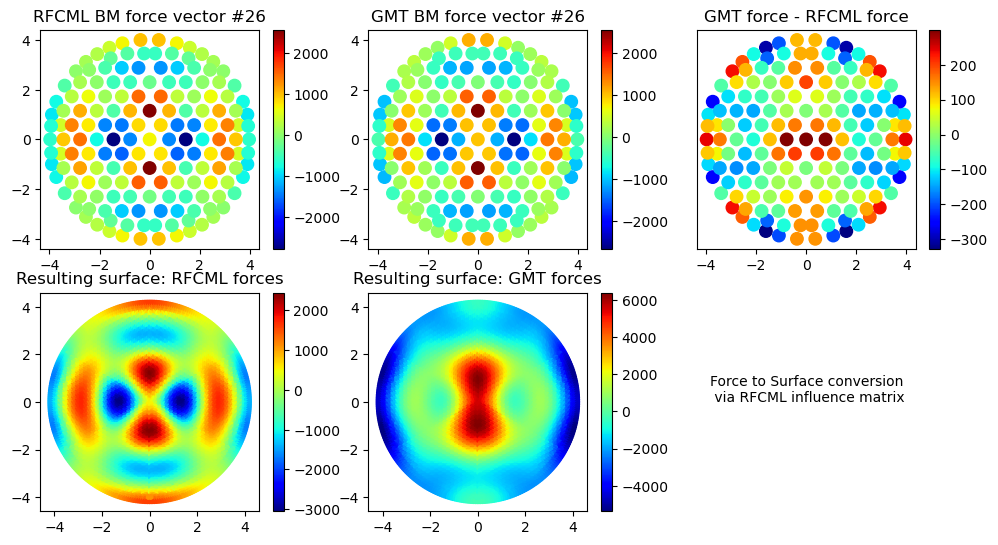

In [65]:
fig, ax = plt.subplots(2,3, figsize=(12,6.25))

modeID = 26
f1 = VMat_ml[:,modeID-1] #ML force for this bm
f2 = -gmtFvec2mlFvec(VMat[:,modeID-1]) #GMT force for this bm, converted onto ML force vector format
img = ax[0][0].scatter(sax_ml, say_ml,80, f1)
fig.colorbar(img, ax=ax[0][0])
ax[0][0].set_title("RFCML BM force vector #%d"%modeID)

img = ax[0][1].scatter(sax_ml, say_ml,80, f2)
fig.colorbar(img, ax=ax[0][1])
ax[0][1].set_title('GMT BM force vector #%d'%modeID)

idx = np.abs(f1-f2)>0
img = ax[0][2].scatter(sax_ml[~idx], say_ml[~idx],80, marker='o', facecolors='none', edgecolors='k')
img = ax[0][2].scatter(sax_ml[idx], say_ml[idx],80, f2[idx]-f1[idx])
fig.colorbar(img, ax=ax[0][2])
ax[0][2].set_yticks([])
#ax[0][2].set_title('Where force diff > 200N')
ax[0][2].set_title('GMT force - RFCML force')

img = ax[1][0].scatter(nodex_ml, nodey_ml, 10, Afn_ml @ f1)
fig.colorbar(img, ax=ax[1][0])
ax[1][0].set_title('Resulting surface: RFCML forces')
ax[1][1].set_title('Resulting surface: GMT forces')

img = ax[1][1].scatter(nodex_ml, nodey_ml, 10, Afn_ml @ f2)
fig.colorbar(img, ax=ax[1][1])
ax[1][2].axis('off')
ax[1][2].text(.05, .5, 'Force to Surface conversion \n via RFCML influence matrix')

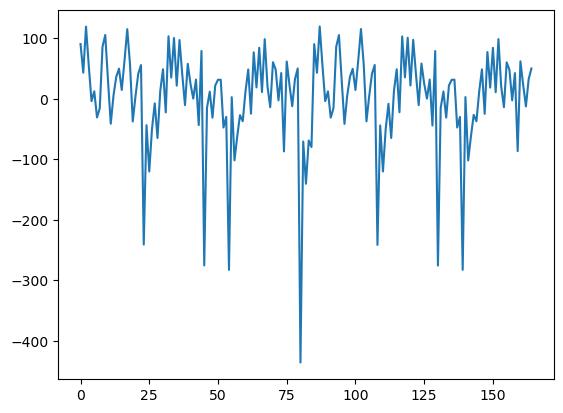

In [79]:
plt.plot(f1-f2)

In [107]:
mat = scipy.io.loadmat('GMT_V_mode26.mat')

In [108]:
Vgmt = mat['V_26_gmt']
Vgmt2ml = mat['V_26_gmt2ml']
print(Vgmt[-5:])

Vgmt[-5:] /= 2
Vgmt = np.squeeze(np.concatenate((Vgmt, Vgmt[-5:])))
print(Vgmt[-5:])

Vgmt2ml = np.squeeze(Vgmt2ml)

[[-0.05581134]
 [-0.2264225 ]
 [ 0.01157363]
 [-0.227753  ]
 [ 0.01085808]]
[-0.02790567 -0.11321125  0.00578682 -0.1138765   0.00542904]


In [109]:
print(Vgmt.shape, Vgmt2ml.shape)

(170,) (165,)


In [110]:
filename = dataFolder+TRIFFolder+'Vz_norm-nohp-%s-%s-%s.csv'%(TRDate[:2],TRDate[2:5],TRDate[5:])
print(filename)
df = pd.read_csv(filename, header=None)
VMat = np.array(df)

/Users/bxin/Library/CloudStorage/OneDrive-SharedLibraries-GMTOCorp/M1S Portal - Documents/influnce_matrix_files/OA_influence_matrices_all/OA_surface_normal_normalised_05Jan2025/Vz_norm-nohp-05-Jan-2025.csv


26
127
-0.012890943857437278 -0.0262194344886587


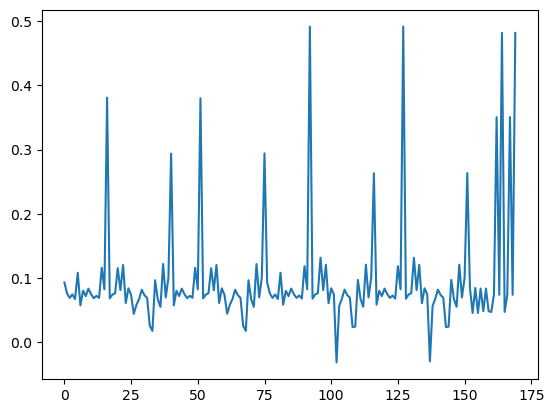

In [114]:
print(modeID)
dd = np.squeeze(Vgmt)/VMat[:,modeID-1]
plt.plot(dd)
idx=np.argmax(dd)
print(idx)
print(Vgmt[idx], VMat[idx,modeID-1])

0.9999999999999994
[-0.59416003 -1.53244497  0.01651122 -1.54389716  0.01127144 -0.59416003
 -1.53244497  0.01651122 -1.54389716  0.01127144]


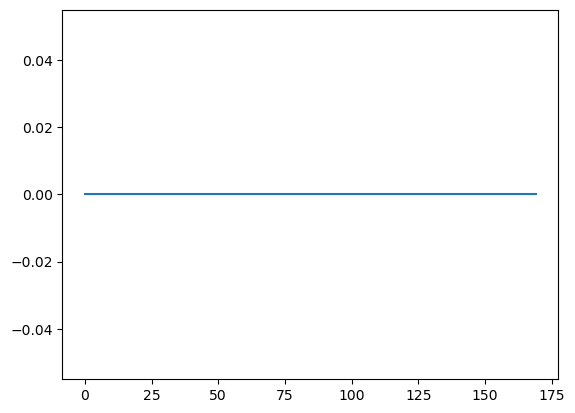

In [144]:
mat = scipy.io.loadmat('V_norm_26.mat')
csv1 = mat['V_norm_26']
csv1 = np.squeeze(csv1)
plt.plot(csv1-VMat[:,modeID-1])
print(np.sqrt(np.mean(VMat[:,modeID-1]**2)))
print(csv1[-10:])

In [134]:
mat = scipy.io.loadmat('V_norm_26_2ml.mat')
csv2 = mat['V_norm_26_2ml']
csv2 = np.squeeze(csv2)
print(csv2[:3], csv2.shape, np.sqrt(np.mean(csv2**2)))
print(csv1[:3], csv1.shape, np.sqrt(np.mean(csv1**2)))
csv15 = csv1/np.sqrt(170)

[-0.00768647  0.09337848 -0.00898669] (165,) 0.07667664079012612
[1.33303579 3.23371635 1.04653004] (170,) 0.9999999999999994


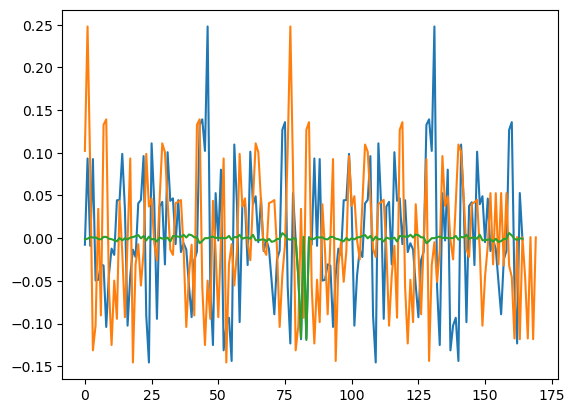

In [141]:
plt.plot(csv2)
plt.plot(csv15)
plt.plot(gmtFvec2mlFvec(csv15)-csv2)

In [142]:
np.sum(csv15), np.sum(csv2), np.sum(gmtFvec2mlFvec(csv15))

(6.661338147750939e-16, 0.2793838320703477, 7.216449660063518e-16)

In [128]:
np.sum(csv1)

7.993605777301127e-15

In [129]:
np.sum(csv2)

0.2793838320703477